## Lesson 7 - In Depth: Machine Learning




### Table of Contents

* [Weather data crawler](#WeatherDataCrawler)
* [Decision Tree](#DecisionTree)
* [Random Forest](#RandomForest)
* [Stochastic gradient descent, SGD](#SGD)
* [Facebook fanpage insights](#FacebookInsights)

<img src="images/will_it_rain_2019.png" width="640">

<a id="WeatherDataCrawler"></a>
## Weather data crawler

Get Weather data from [中央氣象局](https://e-service.cwb.gov.tw/HistoryDataQuery/index.jsp)

In [1]:
import pandas as pd
import numpy as np
import time, datetime, math, requests
import warnings; warnings.simplefilter('ignore')
from urllib.parse import quote, urlparse, unquote
from bs4 import BeautifulSoup as bs
from tqdm import tqdm

In [2]:
def get_weather_data_online(url):
    rs = requests.session()
    html = rs.get(url)
    soup = bs(html.text, "lxml").find({"tbody"})
    month_data = []
    soupss = soup.find_all("tr")

    colname = []
    for j in soupss[1].find_all("th"):
        colname.append(str(j.getText()).split("(")[0])
    
    for i in range(3,len(soupss)):
        row_data = []
        for k in soupss[i].find_all("td"):
            row_data.append(str(k.getText()).strip())
        month_data.append(row_data)
        
    return month_data, colname

In [3]:
# produce datetime that we wanted

start_time = "2018-01"

months_decide = int((datetime.datetime.today() - datetime.datetime.strptime(start_time, "%Y-%m")).days/30)
datetime_list = []
for i in range(1, months_decide+1):
    datetime_list.append(start_time)
    start_time = str(datetime.datetime.strptime(start_time, "%Y-%m") + datetime.timedelta(days=31))[:7]
datetime_list

['2018-01',
 '2018-02',
 '2018-03',
 '2018-04',
 '2018-05',
 '2018-06',
 '2018-07',
 '2018-08',
 '2018-09',
 '2018-10',
 '2018-11',
 '2018-12',
 '2019-01',
 '2019-02',
 '2019-03',
 '2019-04',
 '2019-05',
 '2019-06',
 '2019-07',
 '2019-08',
 '2019-09',
 '2019-10',
 '2019-11',
 '2019-12',
 '2020-01',
 '2020-02',
 '2020-03',
 '2020-04',
 '2020-05',
 '2020-06',
 '2020-07',
 '2020-08',
 '2020-09',
 '2020-10',
 '2020-11',
 '2020-12',
 '2021-01',
 '2021-02',
 '2021-03']

In [4]:
location = "甲仙"

raw_url = "https://e-service.cwb.gov.tw/HistoryDataQuery/MonthDataController.do?command=viewMain&station=466920&stname="+quote(quote(location))+"&datepicker="
all_data = []
for dat_num in tqdm(datetime_list):
    url = raw_url + dat_num
    month_data, colname = get_weather_data_online(url)
    all_data += month_data
    time.sleep(1)
    #print(dat_num, ":\n", url, "\n", "="*120)

100%|████████████████████████████████████████████████████| 39/39 [00:52<00:00,  1.36s/it]


In [5]:
file_raw = pd.DataFrame(all_data, columns=colname)
file_raw['最小相對溼度'] = file_raw['最小相對溼度'].map({'X': 0})
file_raw['露點溫度'] = file_raw['露點溫度'].map({'X': 0})
file_raw['相對溼度'] = file_raw['相對溼度'].map({'X': 0})
file_raw['相對溼度'] = file_raw['相對溼度'].fillna(0)
file_raw.head()

,觀測時間,測站氣壓,海平面氣壓,測站最高氣壓,測站最高氣壓時間,測站最低氣壓,測站最低氣壓時間,氣溫,最高氣溫,最高氣溫時間,...,最大六十分鐘降水量,最大六十分鐘降水量起始時間,日照時數,日照率,全天空日射量,能見度,A型蒸發量,日最高紫外線指數,日最高紫外線指數時間,總雲量
0,01,1018.3,1021.9,1020.4,2018-01-01 09:20,1016.3,2018-01-01 15:35,17.3,19.7,2018-01-01 12:15,...,0.0,...,0.9,8.5,8.23,12.5,2.4,5,2018-01-01 13:00,8.8
1,02,1016.1,1019.7,1018.6,2018-01-02 09:20,1013.3,2018-01-02 14:53,20.4,23.7,2018-01-02 14:42,...,0.0,...,8.4,79.5,13.41,40.0,2.3,6,2018-01-02 12:00,2.0
2,03,1015.2,1018.8,1017.4,2018-01-03 09:28,1013.0,2018-01-03 15:10,21.7,25.4,2018-01-03 12:30,...,0.0,...,5.7,53.9,11.39,27.5,3.8,6,2018-01-03 13:00,6.3
3,04,1013.2,1016.7,1015.1,2018-01-04 09:31,1010.8,2018-01-04 14:44,20.9,24.3,2018-01-04 12:47,...,0.3,2018-01-04 16:10,2.2,20.8,7.68,10.3,-0.4,4,2018-01-04 11:00,9.0
4,05,1014.3,1017.9,1016.1,2018-01-05 09:53,1012.0,2018-01-05 03:08,17.3,18.4,2018-01-05 00:04,...,0.5,2018-01-05 04:14,0.0,0.0,0.40,9.3,-1.0,1,2018-01-05 13:00,10.0


In [6]:
# df.loc[file_raw['最小相對溼度'] == 'X']
# df.loc[file_raw['露點溫度'] == 'X']
# df.loc[file_raw['相對溼度'] == 'X']

In [7]:
def get_rain_bool_col(list_rain):
    list_rain_t = []
    list_rain_raw = []
    for i in list_rain:
        try:
            list_rain_raw.append(float(i))
            if float(i) < 1:
                list_rain_t.append(0)
            else:
                list_rain_t.append(1)
        except Exception as e:
            list_rain_t.append(0)
            list_rain_raw.append(float(0))
    # 假設最後一筆資料明天不會下雨    
    list_tom_rain = list_rain_t[1:] + [0]
    return list_rain_raw, list_tom_rain

In [8]:
file_raw['觀測時間'] = file_raw['測站最高氣壓時間'].apply(lambda x : str(x).split(" ")[0])
file_raw = file_raw[(file_raw["觀測時間"]!="...") & (file_raw["觀測時間"]!=" ") & (file_raw["觀測時間"]!="")]
file_raw['年'] = file_raw['觀測時間'].apply(lambda x : str(x).split("-")[0])
file_raw['月'] = file_raw['觀測時間'].apply(lambda x : str(x).split("-")[1])
file_raw['日'] = file_raw['觀測時間'].apply(lambda x : str(x).split("-")[2])
file_raw['降水量'] = get_rain_bool_col(list(file_raw['降水量']))[0]
file_raw['明日是否下雨'] = get_rain_bool_col(list(file_raw['降水量']))[1]

In [9]:
file_raw.columns

Index(['觀測時間', '測站氣壓', '海平面氣壓', '測站最高氣壓', '測站最高氣壓時間', '測站最低氣壓', '測站最低氣壓時間',
       '氣溫', '最高氣溫', '最高氣溫時間', '最低氣溫', '最低氣溫時間', '露點溫度', '相對溼度', '最小相對溼度',
       '最小相對溼度時間', '風速', '風向', '最大陣風', '最大陣風風向', '最大陣風風速時間', '降水量', '降水時數',
       '最大十分鐘降水量', '最大十分鐘降水量起始時間', '最大六十分鐘降水量', '最大六十分鐘降水量起始時間', '日照時數', '日照率',
       '全天空日射量', '能見度', 'A型蒸發量', '日最高紫外線指數', '日最高紫外線指數時間', '總雲量', '年', '月',
       '日', '明日是否下雨'],
      dtype='object')

In [10]:
stay_col = ['觀測時間', '年', '月', '日', '明日是否下雨', '降水量', '降水時數', '日照時數', '日照率', '全天空日射量', '能見度', '總雲量', '測站氣壓', '海平面氣壓', '氣溫', '最高氣溫', '最低氣溫', '露點溫度', '相對溼度', '最小相對溼度', '風速']
file_raw = file_raw[stay_col]
file_raw.head()

,觀測時間,年,月,日,明日是否下雨,降水量,降水時數,日照時數,日照率,全天空日射量,...,總雲量,測站氣壓,海平面氣壓,氣溫,最高氣溫,最低氣溫,露點溫度,相對溼度,最小相對溼度,風速
0,2018-01-01,2018,01,01,0,0.0,0.0,0.9,8.5,8.23,...,8.8,1018.3,1021.9,17.3,19.7,15.5,NaN,0.0,NaN,3.9
1,2018-01-02,2018,01,02,0,0.0,0.0,8.4,79.5,13.41,...,2.0,1016.1,1019.7,20.4,23.7,17.8,NaN,0.0,NaN,4.4
2,2018-01-03,2018,01,03,0,0.0,0.0,5.7,53.9,11.39,...,6.3,1015.2,1018.8,21.7,25.4,19.8,NaN,0.0,NaN,3.9
3,2018-01-04,2018,01,04,1,0.3,1.2,2.2,20.8,7.68,...,9.0,1013.2,1016.7,20.9,24.3,18.3,NaN,0.0,NaN,1.9
4,2018-01-05,2018,01,05,1,1.0,7.1,0.0,0.0,0.40,...,10.0,1014.3,1017.9,17.3,18.4,16.4,NaN,0.0,NaN,2.1


In [11]:
# Write data into *.csv
file_raw.to_csv("data/weather/rain_raw.csv", encoding='utf_8_sig', header=True, index=False)
# Write data into *.excel
writer = pd.ExcelWriter('data/weather/rain_raw.xlsx', options={'strings_to_urls': False})
file_raw.to_excel(writer,'Sheet1', index = True)
writer.save()

### load weather data with pandas

In [12]:
import pandas as pd
import numpy as np
import time, datetime, math

In [13]:
file = pd.read_csv("data/weather/rain_raw.csv")
file['相對溼度'] = file['相對溼度'].fillna(0)
file['露點溫度'] = file['露點溫度'].fillna(0)
file['最小相對溼度'] = file['最小相對溼度'].fillna(0)
print(file.shape)
file.tail()

(1173, 21)


,觀測時間,年,月,日,明日是否下雨,降水量,降水時數,日照時數,日照率,全天空日射量,...,總雲量,測站氣壓,海平面氣壓,氣溫,最高氣溫,最低氣溫,露點溫度,相對溼度,最小相對溼度,風速
1168,2021-03-14,2021,3,14,0,0.0,0.1,8.1,68.0,21.21,...,5.8,1013.8,1017.4,20.3,23.4,18.4,0.0,0.0,0.0,3.2
1169,2021-03-15,2021,3,15,0,0.0,0.0,9.2,77.1,21.01,...,3.8,1011.1,1014.6,22.7,28.9,18.0,0.0,0.0,0.0,1.6
1170,2021-03-16,2021,3,16,0,0.0,0.0,10.7,89.5,22.52,...,0.8,1010.4,1013.9,23.9,30.0,19.1,0.0,0.0,0.0,1.4
1171,2021-03-17,2021,3,17,0,0.0,0.0,5.2,43.4,15.67,...,5.0,1010.8,1014.3,22.1,26.0,20.3,0.0,0.0,0.0,1.8
1172,2021-03-18,2021,3,18,0,0.0,0.0,1.0,8.3,9.59,...,8.5,1010.4,1013.9,21.6,24.9,19.5,0.0,0.0,0.0,1.1


### load our Excel file: "controlling.xlsx" to select/define features easily

In [14]:
import pandas as pd
file0 = pd.read_excel("data/weather/weather_controller.xlsx")
file0.head()

,所有欄位名稱,所有欄位單位,Unnamed: 2,使用欄位,Unnamed: 4,整數欄位,Unnamed: 6,浮點數欄位,Unnamed: 8,字串欄位,Unnamed: 10,踢除欄位,Unnamed: 12,dummy欄位,Unnamed: 14,訓練前處理欄位
0,觀測時間,(day),NaN,明日是否下雨,NaN,明日是否下雨,NaN,能見度,NaN,觀測時間,NaN,觀測時間,NaN,月,NaN,NaN
1,年,(單位),NaN,觀測時間,NaN,年,NaN,相對溼度,NaN,NaN,NaN,年,NaN,NaN,NaN,NaN
2,月,(單位),NaN,年,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,日,(單位),NaN,能見度,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,明日是否下雨,(單位),NaN,相對溼度,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# kick_nan is for remove NaN coulum
def kick_nan(_list):
    list0 = []
    for i in _list:
        if "nan" not in str(i).lower():
            list0.append(str(i))
    return list0

In [16]:
use_col = kick_nan(list(set(file0['使用欄位'])))
int_col = kick_nan(list(set(file0['整數欄位'])))
str_col = kick_nan(list(set(file0['字串欄位'])))
float_col = kick_nan(list(set(file0['浮點數欄位'])))
drop_col = kick_nan(list(set(file0['踢除欄位'])))
dummy_col = kick_nan(list(set(file0['dummy欄位'])))
pre_col = kick_nan(list(set(file0['訓練前處理欄位'])))
print("use_col: ", use_col)
print("int_col: ", int_col)
print("str_col: ", str_col)
print("float_col: ", float_col)
print("drop_col: ", drop_col)
print("dummy_col: ", dummy_col)
print("pre_col: ", pre_col)

use_col:  ['明日是否下雨', '相對溼度', '能見度', '月', '觀測時間', '年']
int_col:  ['明日是否下雨', '年']
str_col:  ['觀測時間']
float_col:  ['相對溼度', '能見度']
drop_col:  ['年', '觀測時間']
dummy_col:  ['月']
pre_col:  []


### data cleaning, prepare process data
key concepts:
1. 資料清洗 (nan, err)
2. 資料形別 (string, integer, float; dataframe, list, array, matrix)
3. 資料不對襯 (delete data; add more data)

In [17]:
def preprocessing_before_training(file, use_col, int_col, float_col, str_col):
    # 1. 資料清洗 (nan, err)
    # pick the column that we wanted
    file = file[use_col]
    
    # 2. 資料形別 (string, integer, float; dataframe, list, array, matrix)    
    # transfer some of columns into float
    if len(float_col) > 0:
        for i in float_col:
            file[i] = file[i].apply(lambda x : float(str(x)))

    # transfer some of columns into int
    if len(int_col) > 0:
        for i in int_col:
            file[i] = file[i].apply(lambda x : int(float(str(x))))

    # transfer some of columns into str
    if len(str_col) > 0:
        for i in str_col:
            file[i] = file[i].apply(lambda x : str(x))    
    return file

In [18]:
# We're using year 2018 to train model, and forecast year 2021 later
file = preprocessing_before_training(file, use_col, int_col, float_col, str_col)
df = file[file["年"]!=2021]
print(df.shape)
df.head()

(1096, 6)


,明日是否下雨,相對溼度,能見度,月,觀測時間,年
0,0,0.0,12.5,1,2018-01-01,2018
1,0,0.0,40.0,1,2018-01-02,2018
2,0,0.0,27.5,1,2018-01-03,2018
3,1,0.0,10.3,1,2018-01-04,2018
4,1,0.0,9.3,1,2018-01-05,2018


In [19]:
# 明天有下雨
df.loc[df['觀測時間'] == "2018-01-05"]

,明日是否下雨,相對溼度,能見度,月,觀測時間,年
4,1,0.0,9.3,1,2018-01-05,2018


In [20]:
# 明天不下雨
df.loc[df['觀測時間'] == "2018-02-14"]

,明日是否下雨,相對溼度,能見度,月,觀測時間,年
44,0,0.0,24.8,2,2018-02-14,2018


In [21]:
from sklearn.utils import shuffle

# 3. 資料不對襯 (delete data; add more data)
def remove_too_much_data(df, boundary_number, check_col_name):
    count = 0
    work_time_dic = {}
    check_list = list(df[check_col_name])
    for i in set(check_list):
        if i not in work_time_dic:
            work_time_dic[i] = check_list.count(i)
        else:
            pass
    df0 = pd.DataFrame([], columns=df.columns)
    for i in work_time_dic:
        count+=1
        if work_time_dic[i] < boundary_number:
            df_less = df[df[check_col_name] == i]
            df0 = pd.concat([df0, df_less])
        else:
            df_too_much = df[df[check_col_name] == i]
            df_too_much = shuffle(df_too_much).reset_index(drop=True)
            remove_n = work_time_dic[i] - boundary_number
            drop_indices = np.random.choice(df_too_much.index, remove_n, replace=False)
            df_too_much = df_too_much.drop(drop_indices)
            df0 = pd.concat([df0, df_too_much])
    return df0

In [22]:
print("shape of df: ", df.shape)
print("多少2018資料顯示該資料明日不會下雨 (0): ", list(df["明日是否下雨"]).count(0))
print("多少2018資料顯示該資料明日會下雨 (1): ", list(df["明日是否下雨"]).count(1))

shape of df:  (1096, 6)
多少2018資料顯示該資料明日不會下雨 (0):  727
多少2018資料顯示該資料明日會下雨 (1):  369


In [23]:
print("shape of df: ", df.shape)
df = remove_too_much_data(df, min(list(df["明日是否下雨"]).count(0), list(df["明日是否下雨"]).count(1)), "明日是否下雨")
print("多少2018資料顯示該資料明日不會下雨 (0): ", list(df["明日是否下雨"]).count(0))
print("多少2018資料顯示該資料明日會下雨 (1): ", list(df["明日是否下雨"]).count(1))

shape of df:  (1096, 6)
多少2018資料顯示該資料明日不會下雨 (0):  369
多少2018資料顯示該資料明日會下雨 (1):  369


### preprocessing for training
key concepts:
1. dummy column (dummy)
2. 資料前處理 (normalize; scale)
3. 移除 column (drop)

In [24]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn import ensemble, preprocessing, metrics

def preprocessing_for_training(file, dummy_col, pre_col=[], pre_meth=""):
    # 1. dummy column (dummy)
    column_need_dummy = dummy_col
    if len(column_need_dummy) > 0:
        for i in column_need_dummy:
            file = pd.concat([file, pd.get_dummies(file[i], prefix=[i])], axis=1)
    else:
        pass
    if len(column_need_dummy) > 0:
        file = file.drop(column_need_dummy, axis=1)
    else:
        pass

    # 2. 資料前處理 (normalize; scale)
    preprocessing_column = pre_col
    #X_train, X_test, y_train, y_test = train_test_split(file.drop(["明日是否下雨"], axis=1), file["明日是否下雨"], test_size=0.3, random_state=101)
    X_train, X_test, y_train, y_test = train_test_split(file.drop(["明日是否下雨"], axis=1), file["明日是否下雨"], test_size=0.3, random_state=101)
    if preprocessing_column != []:
        if pre_meth == "method1":
            mean_tra = list(np.mean(X_train[preprocessing_column], axis=0))
            std_tra = list(np.std(X_train[preprocessing_column], axis=0)  )
            X_train[preprocessing_column] = sklearn.preprocessing.scale(X_train[preprocessing_column])
            X_test[preprocessing_column] = (X_test[preprocessing_column]-mean_tra)/std_tra
            pre_info = ["method1", mean_tra, std_tra]
        else:
            pre_info = ["no_pre", 0, 0]
    else:
        pre_info = ["no_pre", 0, 0]
    
    return X_train, X_test, y_train, y_test, pre_info

In [25]:
X_train, X_test, y_train0, y_test0, pre_info = preprocessing_for_training(df, dummy_col, pre_col, "")

In [26]:
# 分2類: method1 手刻
y_train = [] 
for i in y_train0:
    y_train.append([int(1-i), i])
y_train = np.array(y_train)
y_test = [] 
for i in y_test0:
    y_test.append([int(1-i), i])
y_test = np.array(y_test)
# 分2類: method2 keras
# from keras.utils import np_utils
# y_train = np_utils.to_categorical(y_train, num_classes = 2)
# y_test = np_utils.to_categorical(y_test, num_classes = 2)

### preprocessed 的結果

In [27]:
# dimension of different data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(516, 16)
(222, 16)
(516, 2)
(222, 2)


In [28]:
# data after processed
X_test.head()

,相對溼度,能見度,觀測時間,年,['月']_1,['月']_2,['月']_3,['月']_4,['月']_5,['月']_6,['月']_7,['月']_8,['月']_9,['月']_10,['月']_11,['月']_12
280,0.0,17.8,2019-10-24,2019,0,0,0,0,0,0,0,0,0,1,0,0
719,0.0,35.0,2020-01-05,2020,1,0,0,0,0,0,0,0,0,0,0,0
663,0.0,24.3,2018-01-12,2018,1,0,0,0,0,0,0,0,0,0,0,0
19,0.0,27.0,2018-10-03,2018,0,0,0,0,0,0,0,0,0,1,0,0
254,0.0,23.8,2018-04-01,2018,0,0,0,1,0,0,0,0,0,0,0,0


In [29]:
#X_test.loc[(X_test['觀測時間'] == "2018-08-05") & (df['相對溼度'] == 65.0) & (df['月']==8)]
# 明天會下雨
X_train.loc[(X_train['觀測時間'] == "2018-10-03")]

,相對溼度,能見度,觀測時間,年,['月']_1,['月']_2,['月']_3,['月']_4,['月']_5,['月']_6,['月']_7,['月']_8,['月']_9,['月']_10,['月']_11,['月']_12


In [30]:
# 明天不會下雨
X_train.loc[(X_train['觀測時間'] == "2018-09-18")]

,相對溼度,能見度,觀測時間,年,['月']_1,['月']_2,['月']_3,['月']_4,['月']_5,['月']_6,['月']_7,['月']_8,['月']_9,['月']_10,['月']_11,['月']_12


In [31]:
# 1,0 明天會下雨; 0,1 明天不下雨
y_test[:5]

array([[1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0]])

<a id="DecisionTree"></a>
## Decision Tree

In [32]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble, preprocessing, metrics

Hint: choose which column need to be droped wisely

In [33]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)

In [34]:
# 3. 移除 column (drop)
column_will_be_droped = list(set(drop_col))
if len(column_will_be_droped) > 0:
    tree.fit(X_train.drop(column_will_be_droped, axis=1), y_train)
else:
    tree.fit(X_train, y_train)

In [35]:
print("model: ")
print(tree)
print("feature: ")
print(tree.feature_importances_)

model: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
feature: 
[0.         0.57074506 0.03799105 0.02965882 0.         0.
 0.         0.         0.         0.19430138 0.14006599 0.
 0.0272377  0.        ]


In [36]:
X_test[:5]

,相對溼度,能見度,觀測時間,年,['月']_1,['月']_2,['月']_3,['月']_4,['月']_5,['月']_6,['月']_7,['月']_8,['月']_9,['月']_10,['月']_11,['月']_12
280,0.0,17.8,2019-10-24,2019,0,0,0,0,0,0,0,0,0,1,0,0
719,0.0,35.0,2020-01-05,2020,1,0,0,0,0,0,0,0,0,0,0,0
663,0.0,24.3,2018-01-12,2018,1,0,0,0,0,0,0,0,0,0,0,0
19,0.0,27.0,2018-10-03,2018,0,0,0,0,0,0,0,0,0,1,0,0
254,0.0,23.8,2018-04-01,2018,0,0,0,1,0,0,0,0,0,0,0,0


In [37]:
X_test.drop(column_will_be_droped, axis=1)[:5]

,相對溼度,能見度,['月']_1,['月']_2,['月']_3,['月']_4,['月']_5,['月']_6,['月']_7,['月']_8,['月']_9,['月']_10,['月']_11,['月']_12
280,0.0,17.8,0,0,0,0,0,0,0,0,0,1,0,0
719,0.0,35.0,1,0,0,0,0,0,0,0,0,0,0,0
663,0.0,24.3,1,0,0,0,0,0,0,0,0,0,0,0
19,0.0,27.0,0,0,0,0,0,0,0,0,0,1,0,0
254,0.0,23.8,0,0,0,1,0,0,0,0,0,0,0,0


In [38]:
if len(column_will_be_droped) > 0:
    accuracy = metrics.accuracy_score(y_test, tree.predict(X_test.drop(column_will_be_droped, axis=1)))
else:
    accuracy = metrics.accuracy_score(y_test, tree.predict(X_test))
print("accuracy for Decision Tree classification", accuracy)

accuracy for Decision Tree classification 0.6036036036036037


### Save Decision Tree model

In [39]:
import pickle
with open('model/Sklearn/DecisionTree/model_weather_decision_tree.pkl', 'wb') as handle:
    pickle.dump(tree, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load Decision Tree model

In [40]:
import pickle
with open('model/Sklearn/DecisionTree/model_weather_decision_tree.pkl', 'rb') as handle:
    tree_model = pickle.load(handle)

In [41]:
test_subject = [[89.0 ,9.3,1,0,0,0,0,0,0,0,0,0,0,0]] # 2018年01月05 # 明天下雨
# test_subject = [[64.0,24.8,0,1,0,0,0,0,0,0,0,0,0,0]] # 2018年02月14 # 明天不下雨

tree_model.predict(test_subject)

array([[0, 1]])

In [42]:
class_label = {
    0:'明天不下雨',
    1:'明天下雨'
}

def predict_tree(tree_model, test_subject, class_label):
    test_data = np.array(test_subject).astype(np.float)
    predict_result = tree_model.predict(test_data)
    top1 = predict_result.argsort()[-2:][::-1]
    ps = []
    for i in class_label:
        ps.append({class_label[i]:predict_result[0][i]})
    #print(ps)
    return predict_result.argmax(), class_label[predict_result.argmax()], ps
res = predict_tree(tree_model, test_subject, class_label)

In [43]:
res

(1, '明天下雨', [{'明天不下雨': 0}, {'明天下雨': 1}])

<a id="RandomForest"></a>
## Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn import ensemble, preprocessing, metrics

In [45]:
forest = RandomForestClassifier(n_estimators=5, max_depth=4, random_state=0)

In [46]:
# 3. 移除 column (drop)
column_will_be_droped = list(set(drop_col))
if len(column_will_be_droped) > 0:
    model_random_forest = forest.fit(X_train.drop(column_will_be_droped, axis=1), y_train)
else:
    model_random_forest = forest.fit(X_train, y_train)

In [47]:
print("model: ")
print(forest)
print("feature: ")
print(forest.feature_importances_)

model: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
feature: 
[0.         0.726518   0.02828109 0.00708054 0.03572401 0.00611186
 0.         0.00243105 0.01889978 0.07554415 0.08102747 0.00680689
 0.00516023 0.00641494]


In [48]:
if len(column_will_be_droped) > 0:
    accuracy = metrics.accuracy_score(y_test, forest.predict(X_test.drop(column_will_be_droped, axis=1)))
else:
    accuracy = metrics.accuracy_score(y_test, forest.predict(X_test))
print("accuracy for Random Forest classification", accuracy)

accuracy for Random Forest classification 0.5720720720720721


### Save Random Forest model

In [49]:
import pickle
with open('model/Sklearn/RandomForest/model_weather_random_forest.pkl', 'wb') as handle:
    pickle.dump(forest, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load Random Forest model

In [50]:
import pickle
with open('model/Sklearn/RandomForest/model_weather_random_forest.pkl', 'rb') as handle:
    forest_model = pickle.load(handle)

In [51]:
test_subject = [[89.0 ,9.3,1,0,0,0,0,0,0,0,0,0,0,0]] # 2018年01月05 # 明天下雨
test_subject = [[64.0,24.8,0,1,0,0,0,0,0,0,0,0,0,0]] # 2018年02月14 # 明天不下雨
forest_model.predict(test_subject)

array([[1, 0]])

In [52]:
class_label = {
    0:'明天不下雨',
    1:'明天下雨'
}

def predict_forest(forest_model, test_subject, class_label):
    test_data = np.array(test_subject).astype(np.float)
    predict_result = forest_model.predict(test_data)
    top1 = predict_result.argsort()[-2:][::-1]
    ps = []
    for i in class_label:
        ps.append({class_label[i]:predict_result[0][i]})
    #print(ps)
    return predict_result.argmax(), class_label[predict_result.argmax()], ps
res = predict_forest(tree_model, test_subject, class_label)

In [53]:
res

(0, '明天不下雨', [{'明天不下雨': 1}, {'明天下雨': 0}])

<a id="SGD"></a>
## Stochastic gradient descent, SGD (梯度下降法)

In [54]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
from sklearn import ensemble, preprocessing, metrics

In [55]:
# loss="hinge"
# loss="log"
SGD = SGDClassifier(loss="hinge", penalty="l2", max_iter=10)

In [56]:
# 3. 移除 column (drop)
column_will_be_droped = list(set(drop_col))
if len(column_will_be_droped) > 0:
    model_sgd = SGD.fit(X_train.drop(column_will_be_droped, axis=1), list(y_train[:,1]))
else:
    model_sgd = SGD.fit(X_train, list(y_train))

In [57]:
print("model: ")
print(SGD)
print("coef: ")
print(SGD.coef_ )

model: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=10,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
coef: 
[[  0.         -57.63922715 -55.20376685 -30.84916383   3.2472804
   -1.6236402   -8.11820101  12.98912161  30.84916383 118.5257347
   94.17113168   1.6236402  -77.93472966 -11.36548141]]


In [58]:
if len(column_will_be_droped) > 0:
    accuracy = list(SGD.predict(X_test.drop(column_will_be_droped, axis=1)) - list(y_test[:,1])).count(0)/len(list(y_test[:,1]))
else:
    accuracy = list(SGD.predict(X_test) - list(y_test[:,1])).count(0)/len(list(y_test[:,1]))
print("accuracy for SGD classification", accuracy)

accuracy for SGD classification 0.5


### Save SGD model

In [59]:
import pickle
with open('model/Sklearn/SGD/model_weather_sgd.pkl', 'wb') as handle:
    pickle.dump(model_sgd, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load SGD model

In [60]:
import pickle
with open('model/Sklearn/SGD/model_weather_sgd.pkl', 'rb') as handle:
    model_sgd = pickle.load(handle)

In [61]:
test_subject = [[89.0 ,9.3,1,0,0,0,0,0,0,0,0,0,0,0]] # 2018年01月05 # 明天下雨
# test_subject = [[64.0,24.8,0,1,0,0,0,0,0,0,0,0,0,0]] # 2018年02月14 # 明天不下雨
model_sgd.predict(test_subject)

array([0])

In [62]:
class_label = {
    0:'明天不下雨',
    1:'明天下雨'
}

def predict_sgd(sgd_model, test_subject, class_label):
    test_data = np.array(test_subject).astype(np.float)
    predict_result = sgd_model.predict(test_data)
    top1 = predict_result.argsort()[-2:][::-1]
    ps = []
    for i in class_label:
        ps.append({class_label[i]:predict_result[0][i]})
    return predict_result.argmax(), class_label[predict_result.argmax()], ps
res = predict_sgd(tree_model, test_subject, class_label)

In [63]:
res

(1, '明天下雨', [{'明天不下雨': 0}, {'明天下雨': 1}])

### Verification results

In [64]:
model = tree

In [65]:
df_verify = file[file["年"]==2019]
df_verify = df_verify.sort_values("觀測時間")
df_verify.head()

,明日是否下雨,相對溼度,能見度,月,觀測時間,年
365,1,0.0,15.3,1,2019-01-01,2019
366,1,0.0,12.5,1,2019-01-02,2019
367,0,0.0,10.3,1,2019-01-03,2019
368,1,0.0,19.5,1,2019-01-04,2019
369,1,0.0,7.5,1,2019-01-05,2019


In [66]:
def preprocessing_for_validiting(df_verify, dummy_col, pre_col, pre_info):
    X_val = df_verify
    column_need_dummy = dummy_col
    if len(column_need_dummy) > 0:
        for i in column_need_dummy:
            X_val = pd.concat([X_val, pd.get_dummies(df_verify[i], prefix=[i])], axis=1)
    else:
        pass
    if len(column_need_dummy) > 0:
        X_val = X_val.drop(column_need_dummy, axis=1)
    else:
        pass
    if "月" in df_verify.columns:
        for col_mon_num in range(1,13):
            col_mon =  "['月']_" + str(col_mon_num)
            if col_mon not in X_val.columns:
                X_val[col_mon] = [0]*int(X_val.shape[0])
    else:
        pass
    if pre_info[0] == "method1":
        mean_tra = list(pre_info[1])
        std_tra = list(pre_info[2])
        X_val[pre_col] = (X_val[pre_col]-mean_tra)/std_tra
    else:
        pass
    
    y_val0 = df_verify["明日是否下雨"]
    y_val = [] 
    for i in y_val0:
        y_val.append([int(1-i), i])
    y_val = np.array(y_val)
    return X_val, y_val

In [67]:
X_val, y_val = preprocessing_for_validiting(df_verify, dummy_col, pre_col, pre_info)

In [68]:
X_val.tail()

,明日是否下雨,相對溼度,能見度,觀測時間,年,['月']_1,['月']_2,['月']_3,['月']_4,['月']_5,['月']_6,['月']_7,['月']_8,['月']_9,['月']_10,['月']_11,['月']_12
725,0,0.0,11.3,2019-12-27,2019,0,0,0,0,0,0,0,0,0,0,0,1
726,1,0.0,43.8,2019-12-28,2019,0,0,0,0,0,0,0,0,0,0,0,1
727,1,0.0,9.8,2019-12-29,2019,0,0,0,0,0,0,0,0,0,0,0,1
728,0,0.0,14.5,2019-12-30,2019,0,0,0,0,0,0,0,0,0,0,0,1
729,0,0.0,15.0,2019-12-31,2019,0,0,0,0,0,0,0,0,0,0,0,1


In [69]:
y_val[:5]

array([[0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1]])

In [70]:
# Join Table
column_will_be_droped_val = list(set(column_will_be_droped+["明日是否下雨"]))

JoinTable_val = df_verify[["觀測時間", "明日是否下雨"]]

try:
    try:
        JoinTable_val["模型預測值"] = model.predict(X_val.drop(column_will_be_droped_val, axis=1))[:, 1]
    except Exception as e:
        JoinTable_val["模型預測值"] = model.predict(X_val)[:, 1]
except Exception as e:
    try:
        JoinTable_val["模型預測值"] = model.predict(X_val.drop(column_will_be_droped_val, axis=1))
    except Exception as e:
        JoinTable_val["模型預測值"] = model.predict(X_val)

JoinTable_val["模型預測值"] = JoinTable_val["模型預測值"].apply(lambda x: int(x))
for col_nam in use_col:
    JoinTable_val[col_nam] = df_verify[col_nam]

In [71]:
# verify
accuracy = metrics.accuracy_score(JoinTable_val["明日是否下雨"], JoinTable_val["模型預測值"])
print("accuracy for classification", accuracy)

accuracy for classification 0.5287671232876713


In [72]:
JoinTable_val.head()

,觀測時間,明日是否下雨,模型預測值,相對溼度,能見度,月,年
365,2019-01-01,1,1,0.0,15.3,1,2019
366,2019-01-02,1,1,0.0,12.5,1,2019
367,2019-01-03,0,1,0.0,10.3,1,2019
368,2019-01-04,1,1,0.0,19.5,1,2019
369,2019-01-05,1,1,0.0,7.5,1,2019


In [73]:
JoinTable_val[JoinTable_val["觀測時間"]=="2019-02-11"]

,觀測時間,明日是否下雨,模型預測值,相對溼度,能見度,月,年
406,2019-02-11,0,1,0.0,16.3,2,2019


### Visulization

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'font/msjh.ttc')

JoinTable_val["年"] = JoinTable_val["觀測時間"].apply(lambda x: int(str(x).split("-")[0]))
JoinTable_val["月"] = JoinTable_val["觀測時間"].apply(lambda x: int(str(x).split("-")[1]))
JoinTable_val["日"] = JoinTable_val["觀測時間"].apply(lambda x: int(str(x).split("-")[2]))
def ck_q(x):
    if x <= 3:
        return 1
    elif (3 < x) and (x <= 6):
        return 2
    elif (6 < x) and (x <= 9):
        return 3
    else:
        return 4
JoinTable_val["季"] = JoinTable_val["月"].apply(lambda x: ck_q(x))

In [76]:
date_check = []
for j in range(1, max(list(JoinTable_val["日"]))+1):
    tmp = JoinTable_val[JoinTable_val["日"] == j]
    tmp = list(abs(tmp["明日是否下雨"]-tmp["模型預測值"]))
    date_check.append([j, tmp.count(0)/len(tmp), tmp.count(1)/len(tmp)])
month_check = []
for j in range(1, max(list(JoinTable_val["月"]))+1):
    tmp = JoinTable_val[JoinTable_val["月"] == j]
    tmp = list(abs(tmp["明日是否下雨"]-tmp["模型預測值"]))
    month_check.append([j, tmp.count(0)/len(tmp), tmp.count(1)/len(tmp)])
quarter_check = []
for j in range(1, max(list(JoinTable_val["季"]))+1):
    tmp = JoinTable_val[JoinTable_val["季"] == j]
    tmp = list(abs(tmp["明日是否下雨"]-tmp["模型預測值"]))
    quarter_check.append([j, tmp.count(0)/len(tmp), tmp.count(1)/len(tmp)])

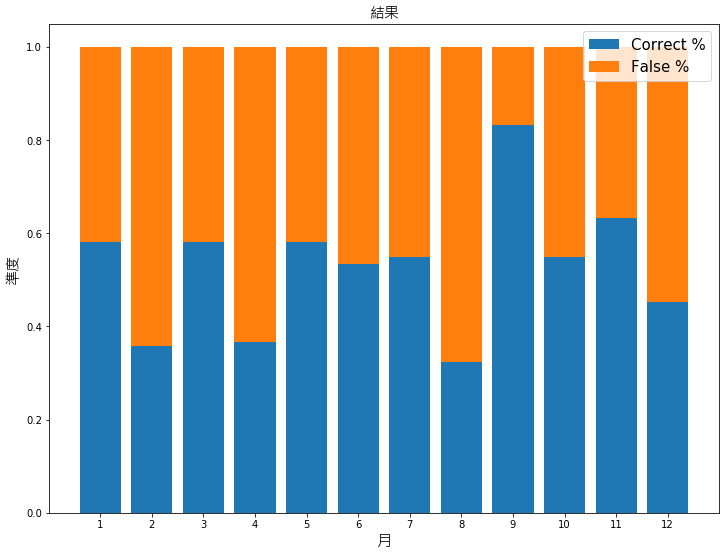

In [77]:
# date_check, month_check, quarter_check
xl = month_check

plt.figure(figsize = (12,9))
plt.bar(np.array(xl)[:,0], np.array(xl)[:,1], label='Correct %') 
plt.bar(np.array(xl)[:,0], np.array(xl)[:,2], bottom=np.array(xl)[:,1], label='False %') 
plt.xticks(np.array(xl)[:,0])
if len(np.array(xl)[:,0]) == 4:
    plt.xlabel("季", fontproperties=myfont, fontsize=15)
elif (len(np.array(xl)[:,0]) > 4) and (len(np.array(xl)[:,0]) < 13):
    plt.xlabel("月", fontproperties=myfont, fontsize=15)
else:
    plt.xlabel("日", fontproperties=myfont, fontsize=15)
plt.ylabel("準度", fontproperties=myfont, fontsize=15)
plt.title('結果', fontproperties=myfont, fontsize=15)
plt.legend(fontsize = 15)
plt.show()

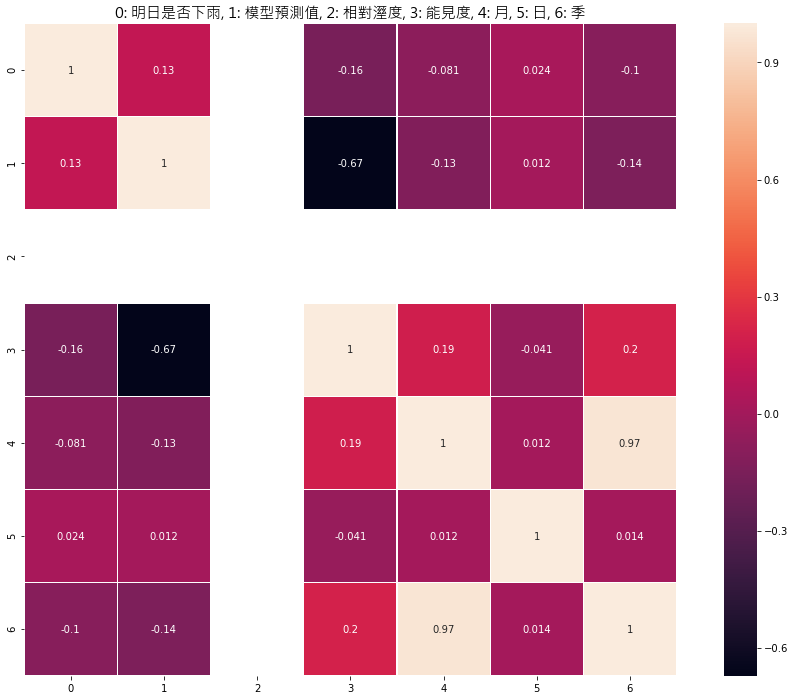

In [78]:
import seaborn as sns

co1 = list(JoinTable_val.columns)
co1.remove("觀測時間")
co1.remove("年")
co0 = ""
for k in range(len(co1)):
    co0+=str(str(k)+": "+str(co1[k])+", ")
co0 = co0[:-2]

plt.figure(figsize=(17,12))
ckv = JoinTable_val[co1].corr()
sns.heatmap(np.array(ckv),linewidths=0.1,vmax=1.0, square=True,linecolor='white',annot=True)
plt.title(co0,fontproperties=myfont, fontsize=15)
plt.show()

<a id="FacebookInsights"></a>
## Facebook fanpage insights
    
### Load data from Excel and do Data preprocessing

<img src="images/will_I_get_more_engagement.png" width="640">

In [79]:
import pandas as pd

df_ = pd.read_excel("data/facebook/fanpage_data_by_day_1.xlsx")
df_['date']= pd.to_datetime(df_['date']) 
df_.head()

,page_fan_adds_unique,date,page_fan_adds,page_impressions_unique,page_posts_impressions_unique,page_fans_online_per_day,page_impressions_organic,page_engaged_users
0,0,2017-10-30,0,0,0,231918,0,0
1,0,2017-10-30,0,0,0,231918,0,0
2,0,2017-10-30,0,0,0,231918,0,0
3,0,2017-10-30,0,0,0,231918,0,0
4,0,2017-10-30,0,0,0,231918,0,0


In [80]:
# 維度說明: https://developers.facebook.com/docs/graph-api/reference/v3.2/insights
# page_fan_adds_unique        說你的粉絲專頁讚的新用戶不重複人數。
# page_fan_adds               說你的粉絲專頁讚的新用戶人數。
# page_impressions_unique     任何來自你粉絲專頁或有關你專頁的內容（包括貼文、限時動態、打卡、廣告、曾與你專頁互動用戶的社交資訊和其他內容）進入其瀏覽畫面的用戶人數。
# page_fans_online_per_day    The number of your fans who saw any posts on Facebook on a given day.
# page_impressions_organic    任何來自你粉絲專頁或有關你專頁的內容（包括貼文、限時動態、打卡、曾與你專頁互動用戶的社交資訊和其他內容）透過未付費散佈進入用戶瀏覽畫面的次數。
# page_engaged_users          與你粉絲專頁互動交流的用戶人數。互動交流包括任何點擊。
df_.dtypes

page_fan_adds_unique                      int64
date                             datetime64[ns]
page_fan_adds                             int64
page_impressions_unique                   int64
page_posts_impressions_unique             int64
page_fans_online_per_day                  int64
page_impressions_organic                  int64
page_engaged_users                        int64
dtype: object

In [81]:
df_.shape[0]

38880

In [82]:
df_ = df_[df_['page_engaged_users'] != 0]

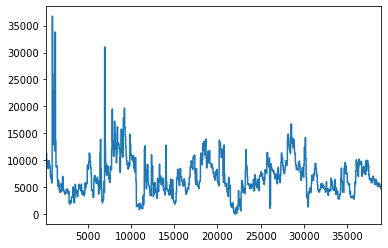

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

# 有點看不懂的圖
df_.page_engaged_users.plot()

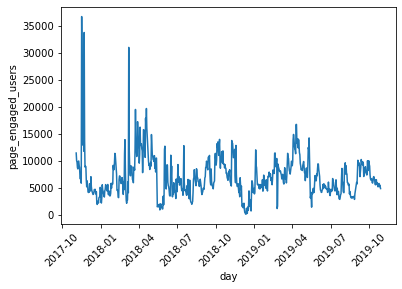

In [84]:
# 加上日期，時間序列，每日粉絲增長數
x_list = df_['date']
y_list = df_['page_engaged_users']
plt.xticks(rotation=45)
plt.xlabel('day')
plt.ylabel('page_engaged_users')
plt.plot(x_list, y_list)

In [85]:
# Matrix form for correlation data
tp = df_.corr()
tp

,page_fan_adds_unique,page_fan_adds,page_impressions_unique,page_posts_impressions_unique,page_fans_online_per_day,page_impressions_organic,page_engaged_users
page_fan_adds_unique,1.000000,0.999676,0.318029,0.485374,-0.317321,0.478930,0.692187
page_fan_adds,0.999676,1.000000,0.318928,0.487175,-0.317777,0.476100,0.691864
page_impressions_unique,0.318029,0.318928,1.000000,0.600810,0.058144,0.098950,0.457307
page_posts_impressions_unique,0.485374,0.487175,0.600810,1.000000,0.075528,0.079564,0.697860
page_fans_online_per_day,-0.317321,-0.317777,0.058144,0.075528,1.000000,-0.070624,-0.079522
page_impressions_organic,0.478930,0.476100,0.098950,0.079564,-0.070624,1.000000,0.558267
page_engaged_users,0.692187,0.691864,0.457307,0.697860,-0.079522,0.558267,1.000000


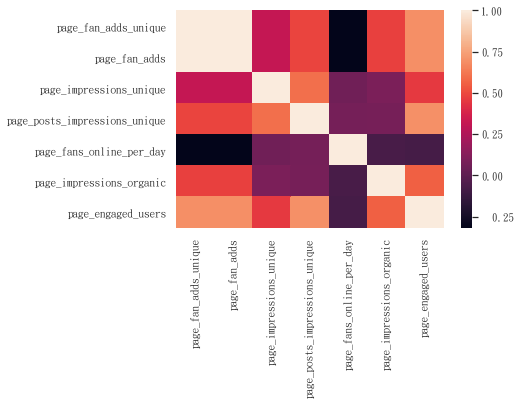

In [86]:
import seaborn as sns
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\kaiu.ttf',size=14)
sns.set(font=myfont.get_name())
%matplotlib inline

sns.heatmap(tp)

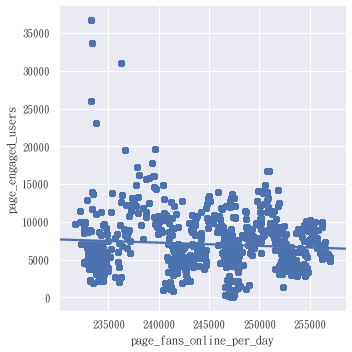

In [87]:
# 每日在線的粉絲數 vs 互動使用者數
sns.lmplot(x='page_fans_online_per_day', y='page_engaged_users', data=df_, palette='coolwarm')

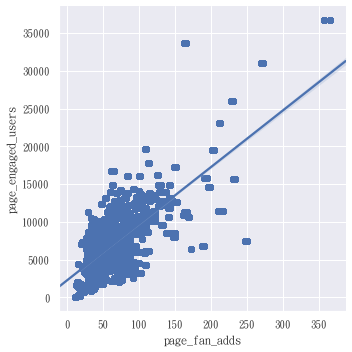

In [88]:
# 每日粉絲新增人數 vs 互動使用者數
sns.lmplot(x='page_fan_adds', y='page_engaged_users', data=df_, palette='coolwarm')

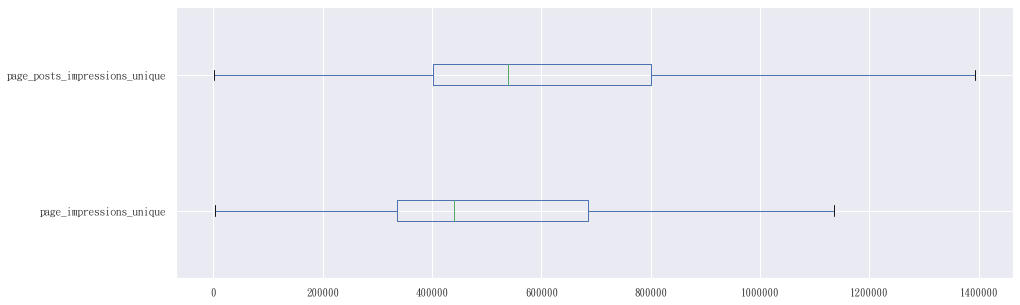

In [89]:
groupbyHousePriceMean = df_.groupby('page_fan_adds').mean()
plot = groupbyHousePriceMean[['page_impressions_unique', 'page_posts_impressions_unique']].plot.box(figsize=(15,5), vert=False, showfliers=False)

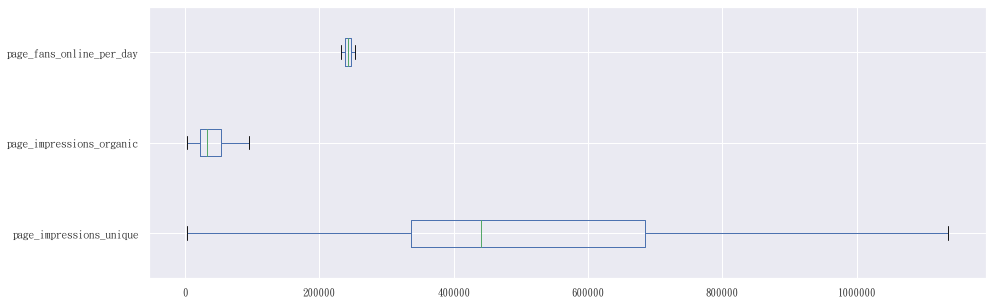

In [90]:
groupbyHousePriceMean = df_.groupby('page_fan_adds').mean()
plot = groupbyHousePriceMean[['page_impressions_unique','page_impressions_organic', 'page_fans_online_per_day']].plot.box(figsize=(15,5), vert=False, showfliers=False)

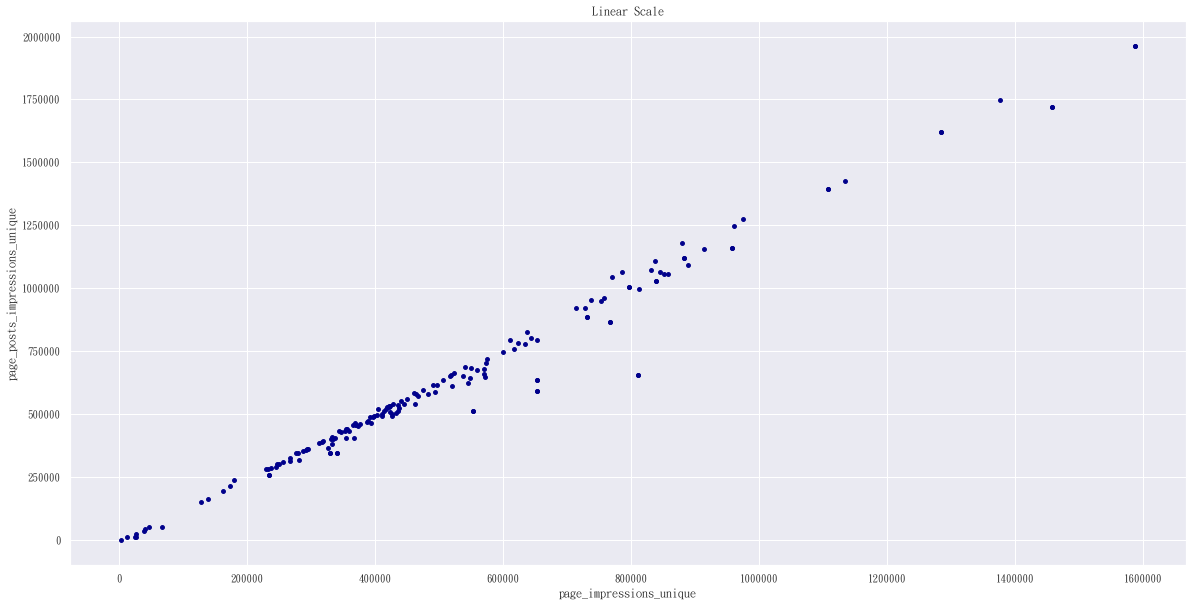

In [91]:
# 每篇文章不重複展示人次與粉絲頁不重複人次成正相關
ax = plt.subplots(ncols=1,figsize=(20,10))
ax[1].title.set_text('Linear Scale')
groupbyHousePriceMean.plot.scatter(x='page_impressions_unique',y='page_posts_impressions_unique',c='DarkBlue',ax=ax[1], s=15)
plt.show()

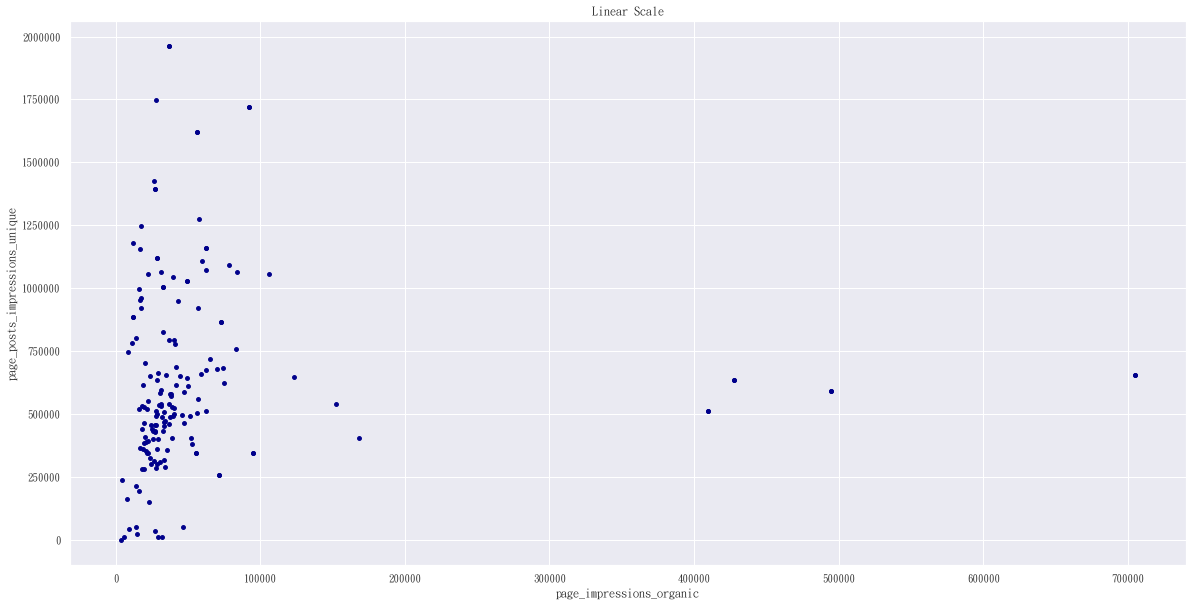

In [92]:
# 每篇文章自然曝光展示人次與粉絲頁不重複觸及人次無相關
ax = plt.subplots(ncols=1,figsize=(20,10))
ax[1].title.set_text('Linear Scale')
groupbyHousePriceMean.plot.scatter(x='page_impressions_organic',y='page_posts_impressions_unique',c='DarkBlue',ax=ax[1], s=15)
plt.show()

### Data preprocessing, training and predict

In [93]:
# drop usless data for training
df_copy = df_.copy()
if 'date' in df_copy.columns:
    del df_copy['date']
if 'date2' in df_copy.columns:
    del df_copy['date2']
df_copy.head()

,page_fan_adds_unique,page_fan_adds,page_impressions_unique,page_posts_impressions_unique,page_fans_online_per_day,page_impressions_organic,page_engaged_users
216,106,106,716821,530107,232150,80063,11417
217,106,106,530107,530107,232150,80063,11417
218,106,106,80063,530107,232150,80063,11417
219,106,106,716821,530107,232150,80063,11417
220,106,106,530107,530107,232150,80063,11417


In [94]:
df_copy.shape[0]

38664

In [95]:
output_data = df_copy[['page_engaged_users']]
output_data.loc[:,'next_engage']=output_data['page_engaged_users'].shift(-1)
output_data=output_data.dropna()
output_data.head()

,page_engaged_users,next_engage
216,11417,11417.0
217,11417,11417.0
218,11417,11417.0
219,11417,11417.0
220,11417,11417.0


In [96]:
output_data.columns

Index(['page_engaged_users', 'next_engage'], dtype='object')

In [97]:
output_data.shape[0]

38663

In [98]:
df_copy = df_copy[:-1]
df_copy.shape[0]

38663

In [99]:
# delete Y
if 'page_engaged_users' in df_copy.columns:
    del df_copy['page_engaged_users']

In [100]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_copy.values, output_data['next_engage'], test_size=0.15)

In [101]:
import numpy as np # linear algebra
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

print(x_train.shape,y_train.shape)
cnn  = MLPRegressor(solver = 'lbfgs')
cnn.fit(x_train, y_train)

cnn.score(x_test, y_test)

(32863, 6) (32863,)


0.7673643526572684

In [102]:
output_data.loc[:,'next_close_diff'] = output_data.loc[:,'next_engage'].diff()
output_data.iloc[0,2] = output_data.iloc[0,1] - output_data.iloc[0,0]

output_data.loc[:,'Engagement_Movement'] = np.where(output_data.loc[:,'next_close_diff']<0,'down','up')

output_data.head()

,page_engaged_users,next_engage,next_close_diff,Engagement_Movement
216,11417,11417.0,0.0,up
217,11417,11417.0,0.0,up
218,11417,11417.0,0.0,up
219,11417,11417.0,0.0,up
220,11417,11417.0,0.0,up


In [103]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(df_copy.values, output_data['Engagement_Movement'], test_size=0.15)

CNNclass = MLPClassifier(solver = 'lbfgs')
CNNclass_model = CNNclass.fit(x_train2, y_train2)

CNNclass.score(x_test2, y_test2)

0.9789655172413793

In [104]:
df_copy[30000:30001]

,page_fan_adds_unique,page_fan_adds,page_impressions_unique,page_posts_impressions_unique,page_fans_online_per_day,page_impressions_organic
30216,68,68,679483,404215,251682,35733


### Predicting if page_engaged_users will go up or down

In [105]:
# page_fan_adds_unique, page_fan_adds, page_impressions_unique, page_posts_impressions_unique, page_fans_online_per_day, page_impressions_organic, page_engaged_users
page_fan_adds_unique = 32
page_fan_adds = 32
page_impressions_unique = 38927
page_posts_impressions_unique = 143308
page_fans_online_per_day = 185417
page_impressions_organic = 38927
# page_engaged_users = 3660

test_ = [[page_fan_adds_unique,page_fan_adds,page_impressions_unique,page_posts_impressions_unique,page_fans_online_per_day,page_impressions_organic]]
CNNclass_model.predict(test_)

array(['up'], dtype='<U4')

In [106]:
page_fan_adds_unique = 20
page_fan_adds = 20
page_impressions_unique = 230
page_posts_impressions_unique = 1295
page_fans_online_per_day = 182436
page_impressions_organic = 3230

test_ = [[page_fan_adds_unique,page_fan_adds,page_impressions_unique,page_posts_impressions_unique,page_fans_online_per_day,page_impressions_organic]]
CNNclass_model.predict(test_)

array(['up'], dtype='<U4')

In [107]:
df_[-1:]

,page_fan_adds_unique,date,page_fan_adds,page_impressions_unique,page_posts_impressions_unique,page_fans_online_per_day,page_impressions_organic,page_engaged_users
38879,62,2019-10-28,62,11332,477376,256993,11332,4827


In [108]:
# 昨天的 page_fan_adds_unique較高，預測今日可以有更高的 page_engaged_users
test_subject = df_copy[-1:].values
CNNclass_model.predict(test_subject)

array(['up'], dtype='<U4')

### Linear Regression of page_engaged_users based on facebook history data

In [109]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
np.random.seed(42)

In [110]:
df_copy = df_.copy()

In [111]:
features = df_copy[['page_fan_adds_unique','page_fan_adds','page_impressions_unique','page_posts_impressions_unique','page_fans_online_per_day','page_impressions_organic']].values
targets = df_copy['page_engaged_users'].shift(periods=-1).fillna(0).values

In [112]:
features[:1]

array([[   106,    106, 716821, 530107, 232150,  80063]], dtype=int64)

In [113]:
targets[:1]

array([11417.])

In [114]:
features.shape[0]

38664

In [115]:
targets.shape[0]

38664

In [116]:
# make sure the same dimension of features and targets count
assert(features,targets)

In [117]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, shuffle=False, random_state=42)

In [118]:
lm = LinearRegression()
# actual training is done in one line of code, sci-kit library takes care of everything
lm.fit(x_train, y_train)
lm.coef_

array([ 7.09951113e+01, -5.54748938e+01,  1.57312620e-04,  7.98966467e-03,
        3.29928879e-02,  3.69886765e-02])

Text(0, 0.5, 'Predicted values with linear model')

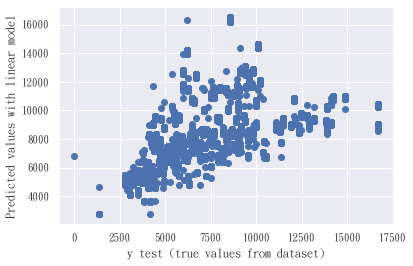

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\kaiu.ttf',size=14)
sns.set(font=myfont.get_name())

%matplotlib inline

predictions = lm.predict(x_test)
plt.scatter(y_test, predictions)
plt.xlabel('y test (true values from dataset)')
plt.ylabel('Predicted values with linear model')

### Linear Regression model evaluation

In [120]:
from sklearn import metrics
print('MAE ', metrics.mean_absolute_error(y_test, predictions))
print('MSE ', metrics.mean_squared_error(y_test, predictions))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE  2073.762880164091
MSE  6607666.443693653
RMSE 2570.5381622714053


MSE is more popular than MAE because MSE "punishes" larger errors. But, RMSE is even more popular than MSE because RMSE is interpretable in the "y" units.

In [121]:
predictions

array([6738.56966242, 6660.43500109, 6789.37393034, ..., 6876.15836449,
       6850.35673513, 6776.99572526])

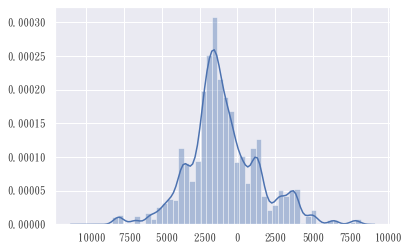

In [122]:
# project on y_test - predictions
sns.distplot((y_test-predictions), bins=50)

In [123]:
# 最後一筆資料(今天)
features[-1:]

array([[    62,     62,  11332, 477376, 256993,  11332]], dtype=int64)

In [124]:
# 預測明日
lm.predict(features[-1:])

array([6776.99572526])

### Save Linear Regression model to pickle

In [125]:
import pickle
with open('model/LinearRegression/model_facebook_page_engaged_users.pkl', 'wb') as handle:
    pickle.dump(lm, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load Linear Regression model to pickle

In [126]:
import pickle
with open('model/LinearRegression/model_facebook_page_engaged_users.pkl', 'rb') as handle:
    lr_model = pickle.load(handle)

In [127]:
def predict_fanpage_page_engaged_users(lr_model, test_data):
    return lr_model.predict([test_data])

In [128]:
page_fan_adds_unique = 32
page_fan_adds = 32
page_impressions_unique = 38927
page_posts_impressions_unique = 143308
page_fans_online_per_day = 185417
page_impressions_organic = 38927

test_ = [page_fan_adds_unique, page_fan_adds, page_impressions_unique, page_posts_impressions_unique, page_fans_online_per_day, page_impressions_organic]
pred_ = predict_fanpage_page_engaged_users(lr_model, test_)
pred_

array([2305.84252635])

### Homework
- Did you notice something wrong, or misunderstand the meaning of each column?
- can you double check each column distribution?

### Hint:
- which column increase by date increase?
- which columns co-related?
- drop columnns and re-train Linear Regression model to see what happenen

In [129]:
# EDA
df_copy = df_.copy()
# if 'date' in df_copy.columns:
#     del df_copy['date']
if 'date2' in df_copy.columns:
    del df_copy['date2']
df_copy[30000:300400]

,page_fan_adds_unique,date,page_fan_adds,page_impressions_unique,page_posts_impressions_unique,page_fans_online_per_day,page_impressions_organic,page_engaged_users
30216,68,2019-05-12,68,679483,404215,251682,35733,10347
30217,68,2019-05-12,68,404215,404215,251682,35733,10347
30218,68,2019-05-12,68,35733,404215,251682,35733,10347
30219,68,2019-05-12,68,679483,404215,251682,35733,10347
30220,68,2019-05-12,68,404215,404215,251682,35733,10347
...,...,...,...,...,...,...,...,...
38875,62,2019-10-28,62,477671,477376,256993,11332,4827
38876,62,2019-10-28,62,11332,477376,256993,11332,4827
38877,62,2019-10-28,62,641686,477376,256993,11332,4827
38878,62,2019-10-28,62,477671,477376,256993,11332,4827


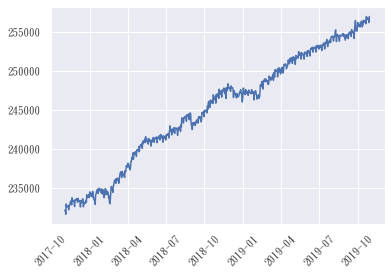

In [130]:
ax = plt.gca()

ax.xaxis_date()
plt.xticks(rotation=45)
plt.plot(df_copy['date'], df_copy['page_fans_online_per_day'])

page_fans_online_per_day 是累計的，無腦train是不行的

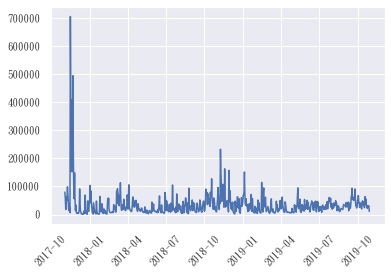

In [131]:
# 自然觸及粉絲頁 impression 數
ax = plt.gca()

ax.xaxis_date()
plt.xticks(rotation=45)
plt.plot(df_copy['date'], df_copy['page_impressions_organic'])

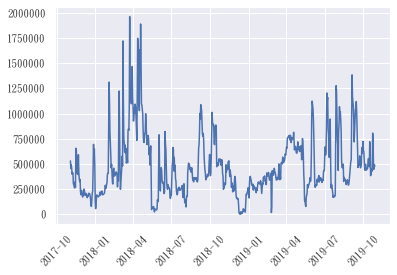

In [132]:
# page_posts_impressions_unique 與發文有關，所以才會時高時低
ax = plt.gca()

ax.xaxis_date()
plt.xticks(rotation=45)
plt.plot(df_copy['date'], df_copy['page_posts_impressions_unique'])

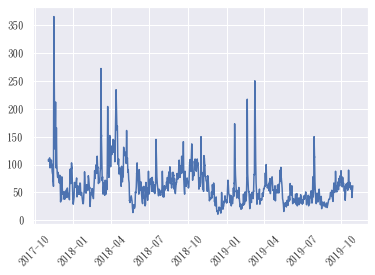

In [133]:
# 每日新增粉絲數
ax = plt.gca()

ax.xaxis_date()
plt.xticks(rotation=45)
plt.plot(df_copy['date'], df_copy['page_fan_adds'])

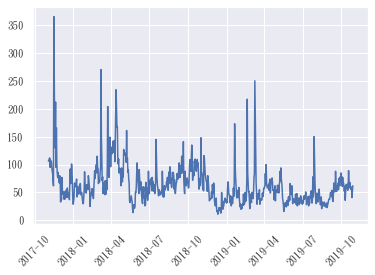

In [134]:
# 每日新增不重複使用者，與 每日新增粉絲數趨勢是雷同的
ax = plt.gca()

ax.xaxis_date()
plt.xticks(rotation=45)
plt.plot(df_copy['date'], df_copy['page_fan_adds_unique'])

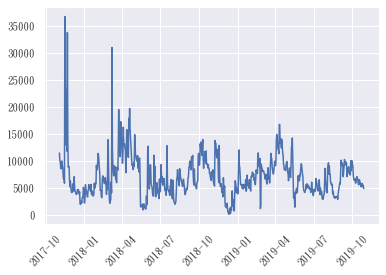

In [135]:
# 檢查我們的 y (粉專觸及人數)
ax = plt.gca()

ax.xaxis_date()
plt.xticks(rotation=45)
plt.plot(df_copy['date'], df_copy['page_engaged_users'])

### Normalized engagement user by comparer page_fan_adds & page_engaged_users

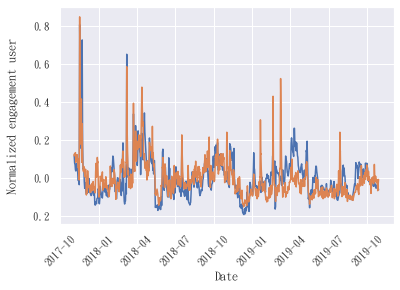

In [136]:
page_engaged_users = (df_copy['page_engaged_users']-df_copy['page_engaged_users'].mean())/(df_copy['page_engaged_users'].max()-df_copy['page_engaged_users'].min())
page_fan_adds = (df_copy['page_fan_adds']-df_copy['page_fan_adds'].mean())/(df_copy['page_fan_adds'].max()-df_copy['page_fan_adds'].min())

plt.plot(df_copy['date'], page_engaged_users, df_copy['date'], page_fan_adds)
plt.xlabel('Date')
plt.ylabel('Normalized engagement user')
plt.xticks(rotation=45)
plt.show()

發現 page_engaged_users 與 page_fan_adds(我們的y)擬合程度似乎有相依

In [137]:
# 刪除相依欄位、重複欄位、持續累加欄位、日期
df_copy = df_.copy()
if 'date' in df_copy.columns:
    del df_copy['date']
if 'date2' in df_copy.columns:
    del df_copy['date2']
if 'page_fans_online_per_day' in df_copy.columns:
    del df_copy['page_fans_online_per_day']
if 'page_fan_adds' in df_copy.columns:
    del df_copy['page_fan_adds']
if 'page_fan_adds_unique' in df_copy.columns:
    del df_copy['page_fan_adds_unique']
df_copy.head()

,page_impressions_unique,page_posts_impressions_unique,page_impressions_organic,page_engaged_users
216,716821,530107,80063,11417
217,530107,530107,80063,11417
218,80063,530107,80063,11417
219,716821,530107,80063,11417
220,530107,530107,80063,11417


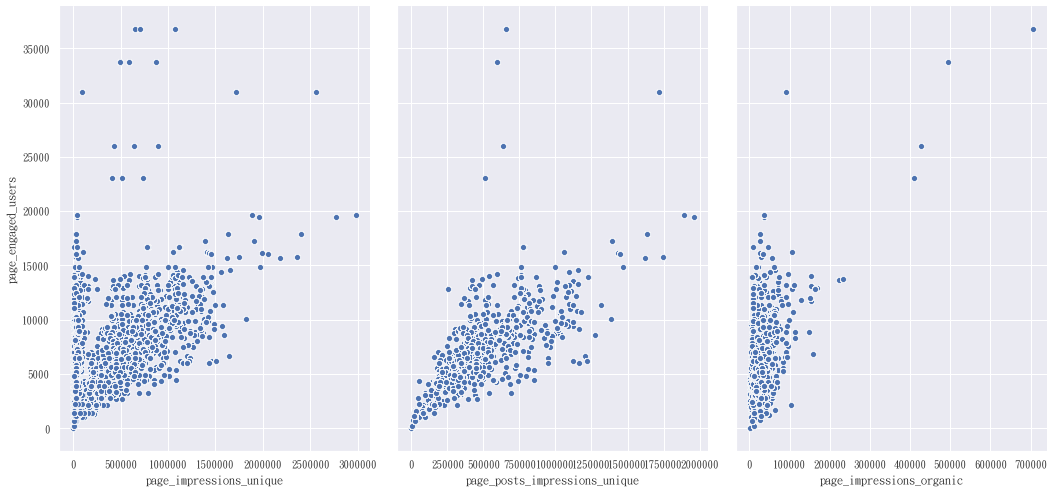

In [138]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(df_copy, x_vars=['page_impressions_unique','page_posts_impressions_unique','page_impressions_organic'], y_vars='page_engaged_users', size=7, aspect=0.7)

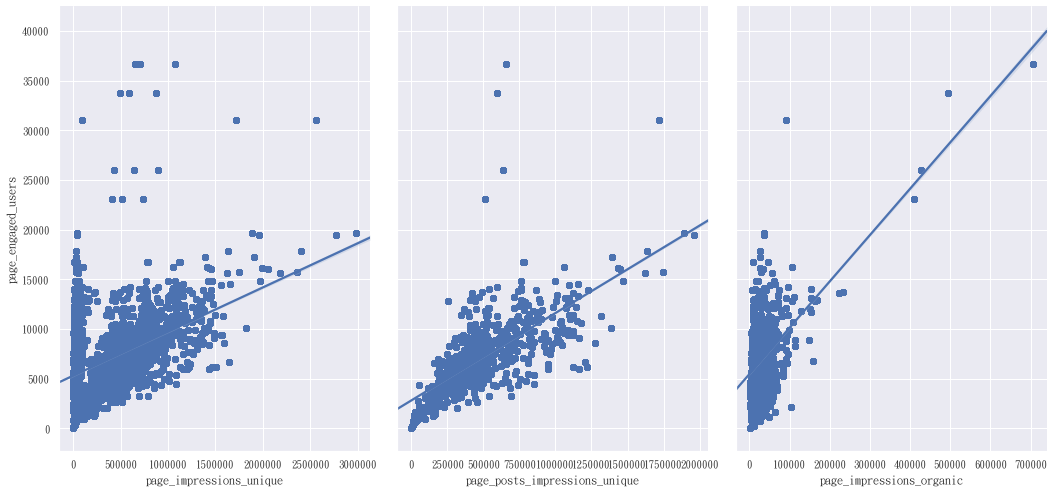

In [139]:
# Plotting the Least Squares Line
sns.pairplot(df_copy, x_vars=['page_impressions_unique','page_posts_impressions_unique','page_impressions_organic'], y_vars='page_engaged_users', size=7, aspect=0.7, kind='reg')

### re-train LinearRegression model and save to v2

In [140]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
np.random.seed(42)

In [141]:
features = df_copy[['page_impressions_unique','page_posts_impressions_unique','page_impressions_organic']].values
targets = df_copy['page_engaged_users'].shift(periods=-1).fillna(0).values

In [142]:
features[:1]

array([[716821, 530107,  80063]], dtype=int64)

In [143]:
targets[:1]

array([11417.])

In [144]:
features.shape[0]

38664

In [145]:
targets.shape[0]

38664

In [146]:
# make sure the same dimension of features and targets count
assert(features,targets)

In [147]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, shuffle=False, random_state=42)

In [148]:
lm = LinearRegression()
# actual training is done in one line of code, sci-kit library takes care of everything
lm.fit(x_train, y_train)
lm.coef_

array([0.00019101, 0.00897277, 0.04194178])

Text(0, 0.5, 'Predicted values with linear model')

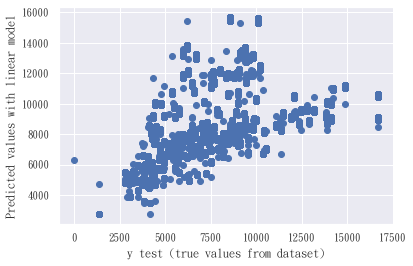

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\kaiu.ttf',size=14)
sns.set(font=myfont.get_name())

%matplotlib inline

predictions = lm.predict(x_test)
plt.scatter(y_test, predictions)
plt.xlabel('y test (true values from dataset)')
plt.ylabel('Predicted values with linear model')

### Linear Regression model evaluation

In [150]:
from sklearn import metrics
print('MAE ', metrics.mean_absolute_error(y_test, predictions))
print('MSE ', metrics.mean_squared_error(y_test, predictions))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE  2111.4752455605085
MSE  7078090.7393687125
RMSE 2660.4681428967933


In [151]:
predictions

array([6736.98706501, 6642.11439145, 6798.67462651, ..., 6416.86383464,
       6385.53497856, 6296.45856838])

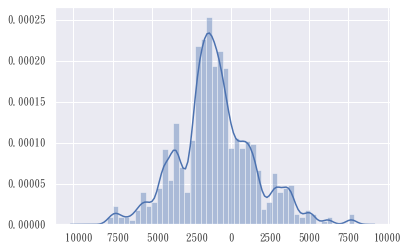

In [152]:
# project on y_test - predictions
sns.distplot((y_test-predictions), bins=50)

In [153]:
# 最後一筆資料(今天)
features[-1:]

array([[ 11332, 477376,  11332]], dtype=int64)

In [154]:
# 預測明日
lm.predict(features[-1:])

array([6296.45856838])

### Save Linear Regression model v2 to pickle

In [155]:
import pickle
with open('model/LinearRegression/model_facebook_page_engaged_users_v2.pkl', 'wb') as handle:
    pickle.dump(lm, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load Linear Regression model v2 to pickle

In [156]:
import pickle
with open('model/LinearRegression/model_facebook_page_engaged_users_v2.pkl', 'rb') as handle:
    lr_model = pickle.load(handle)

In [157]:
def predict_fanpage_page_engaged_users(lr_model, test_data):
    return lr_model.predict([test_data])

In [158]:
page_impressions_unique = 38927
page_posts_impressions_unique = 143308
page_impressions_organic = 38927
test_ = [page_impressions_unique, page_posts_impressions_unique, page_impressions_organic]
pred_ = predict_fanpage_page_engaged_users(lr_model, test_)
pred_

array([4461.59705865])

In [159]:
# print the R-squared value for the model
lm.score(x_test, y_test)

0.15797740524011017

What Does R-Squared Tell You?

R-squared values range from 0 to 1 and are commonly stated as percentages from 0% to 100%. An R-squared of 100% means that all movements of a security (or other dependent variable) are completely explained by movements in the index (or the independent variable(s) you are interested in).

Is this result a "good" R-squared value?

No, it's not.

The threshold for a good R-squared value depends widely on the domain

Therefore, it's most useful as a tool for comparing different models

### What didn't we Cover?
- Detecting collinearity
- Diagnosing model fit
- Transforming features to fit non-linear relationships
- Interaction terms
- Assumptions of linear regression
- Data of this fanpage from 2017-01-01 to 2019-10-28, it's not fair for every day, 'cause that almost from 0 to over 3900!
- Improvement by narrow date that between 1500-3500 page_engaged_users will help or not?
- 

Notes

You could certainly go very deep into linear regression, and learn how to apply it really, really well
It's an excellent way to start your modeling process when working a regression problem
However, it is limited by the fact that it can only make good predictions if there is a linear relationship between the features and the response, which is why more complex methods (with higher variance and lower bias) will often outperform linear regression
